In [1]:
%run setting.ipynb

In [2]:
import os
import re
import pandas as pd
from pandasql import sqldf
import yfinance as yf

pysqldf = lambda q: sqldf(q, globals())

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.express as px

# load data

In [4]:
SSO_simulation = pd.read_excel('SSO_simulation.xlsx')

SSO_simulation.to_sql(
    "SSO_simulation", 
    conn,
    if_exists = "replace",
    )

24095

In [5]:
SPXL_simulation = pd.read_excel('SPXL_simulation.xlsx')

SPXL_simulation.to_sql(
    "SPXL_simulation", 
    conn,
    if_exists = "replace",
    )

24095

In [6]:
QLD_simulation = pd.read_excel('QLD_simulation.xlsx')

QLD_simulation.to_sql(
    "QLD_simulation", 
    conn,
    if_exists = "replace",
    )

9620

In [7]:
TQQQ_simulation = pd.read_excel('TQQQ_simulation.xlsx')

TQQQ_simulation.to_sql(
    "TQQQ_simulation", 
    conn,
    if_exists = "replace",
    )

9620

In [11]:
TQQQ_simulation

Date          ^NDX  simulated_TQQQ       TQQQ
0     1985-10-02    110.824997        0.306700        NaN
1     1985-10-03    110.870003        0.306757        NaN
2     1985-10-04    110.074997        0.305739        NaN
3     1985-10-07    108.199997        0.303373        NaN
4     1985-10-08    107.160004        0.302106        NaN
...          ...           ...             ...        ...
9615  2023-11-27  15961.980469       50.447382  44.049999
9616  2023-11-28  16010.429688       50.904387  44.400002
9617  2023-11-29  15987.599609       50.687735  44.240002
9618  2023-11-30  15947.870117       50.311789  43.869999
9619  2023-12-01  15997.580078       50.779833  44.240002

[9620 rows x 4 columns]

# join the data

In [14]:
sql(f"""
select 
a.Date,
a.`^GSPC`,
b.`^NDX`,
--
case 
    when a.SSO is not null then a.SSO
    else a.simulated_SSO
end as SSO,
--
case 
    when b.TQQQ is not null then b.TQQQ
    else b.simulated_TQQQ
end as TQQQ,
--
case 
    when c.QLD is not null then c.QLD
    else c.simulated_QLD
end as QLD,
--
case 
    when d.SPXL is not null then d.SPXL
    else d.simulated_SPXL
end as SPXL
--
from SSO_simulation as a
--
left join TQQQ_simulation as b on date(b.Date) = date(a.Date)
left join QLD_simulation as c on date(c.Date) = date(a.Date)
left join SPXL_simulation as d on date(d.Date) = date(a.Date)
--
""").to_sql(
    "join_data", 
    conn,
    if_exists = "replace",
    )

24095

In [15]:
sql(f"""
select * 
from join_data
order by Date asc
""").to_csv('join_data.csv')

In [16]:
join_data = pd.read_csv('join_data.csv')

In [18]:
join_data.to_sql(
    "join_data", 
    conn,
    if_exists = "replace",
    )

24095

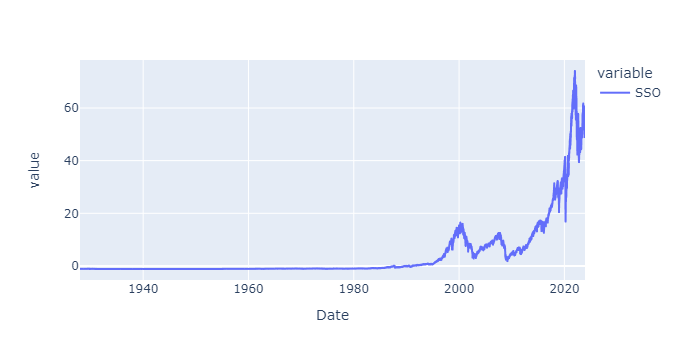

In [44]:
fig = px.line(
join_data, x='Date', 
y = [
f"SSO",
],
)

fig.show()

# return and retio

In [59]:
holding_year = 5

In [60]:
sql(f"""

with 

current as (
select *
from join_data
where `^NDX` is not null
)

select 
a.Date,
a.`^NDX`,
a.QLD,
a.TQQQ,
a.SSO,
a.SPXL,
--
b.Date as Date_previouse,
--
b.`^NDX` as NDX_pre,
b.`^GSPC` as GSPC_pre,
--
b.QLD as QLD_pre,
b.TQQQ as TQQQ_pre,
b.SSO as SSO_pre,
b.SPXL as SPXL_pre,
--
a.`^NDX`/b.`^NDX` as NDX_ratio_{holding_year}_year,
a.QLD/b.QLD as QLD_ratio_{holding_year}_year,
a.TQQQ/b.TQQQ as TQQQ_ratio_{holding_year}_year,
--
a.`^GSPC`/b.`^GSPC` as GSPC_ratio_{holding_year}_year,
a.SSO/b.SSO as SSO_ratio_{holding_year}_year,
a.SPXL/b.SPXL as SPXL_ratio_{holding_year}_year
--
from current as a
join current as b
on date(b.Date, '+{holding_year} year') = date(a.Date)
""").to_sql(
    "data_with_previouse", 
    conn,
    if_exists = "replace",
    )

df = sql(f"""
select * 
from data_with_previouse
order by Date asc
""")

In [61]:
df[[
f"NDX_ratio_{holding_year}_year",
f"QLD_ratio_{holding_year}_year", 
f"TQQQ_ratio_{holding_year}_year",
##
f"GSPC_ratio_{holding_year}_year",
f"SSO_ratio_{holding_year}_year", 
f"SPXL_ratio_{holding_year}_year",
]].median()

NDX_ratio_5_year     1.990559
QLD_ratio_5_year     2.189542
TQQQ_ratio_5_year    2.462485
GSPC_ratio_5_year    1.561518
SSO_ratio_5_year     1.872700
SPXL_ratio_5_year    2.704398
dtype: float64

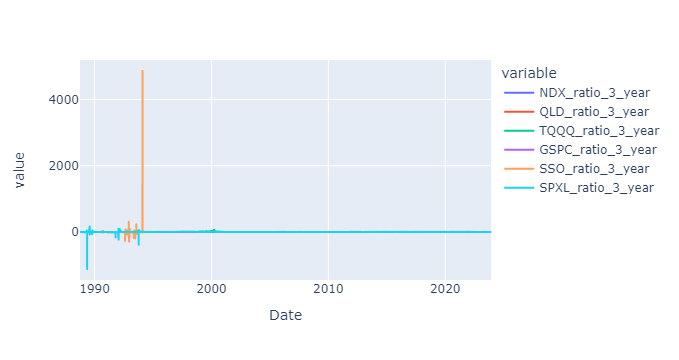

In [49]:
fig = px.line(
df, x='Date', 
y = [
f"NDX_ratio_{holding_year}_year",
f"QLD_ratio_{holding_year}_year", 
f"TQQQ_ratio_{holding_year}_year",
##
f"GSPC_ratio_{holding_year}_year",
f"SSO_ratio_{holding_year}_year", 
f"SPXL_ratio_{holding_year}_year",
],
)

fig.show()

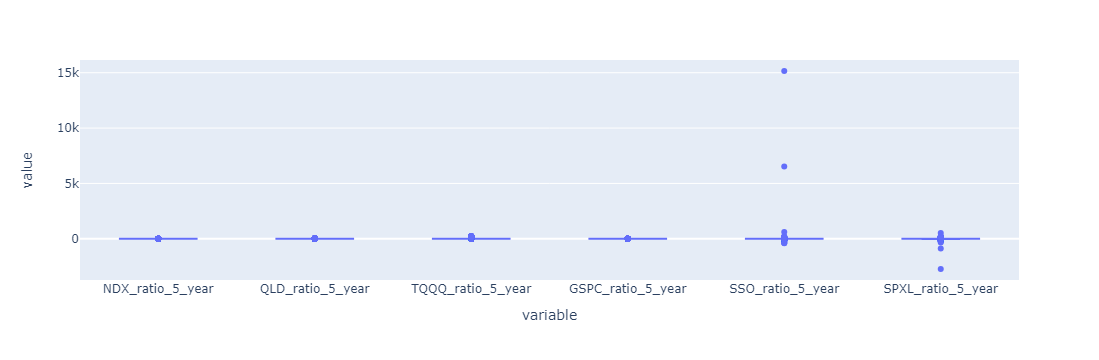

In [62]:
fig = px.box(
df, 
y = [
f"NDX_ratio_{holding_year}_year",
f"QLD_ratio_{holding_year}_year", 
f"TQQQ_ratio_{holding_year}_year",
##
f"GSPC_ratio_{holding_year}_year",
f"SSO_ratio_{holding_year}_year", 
f"SPXL_ratio_{holding_year}_year",
],
)

fig.show()

# END